In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
from scipy.stats import gaussian_kde
import heapq
import copy
import math

In [3]:
def calcModularity(A, x, k):
    n = len(A)
    m = np.sum(np.sum(A))
    # calculate e matrix
    e = [[0 for i in range(k)] for j in range(k)]
    for i in range(n):
        for j in range(n):
            if A[i][j]:
                u = x[i]
                v = x[j]
                e[u][v] += 1
    e = e / m
    # calculate a array
    a = np.sum(e, axis=1)
    # calculate modularity Q
    Q = 0
    for u in range(k):
        Q += (e[u][u] - a[u]*a[u])
    return Q

def calcMinModularity(A, x, k):
    n = len(A)
    mp = np.sum(np.sum(A))
    # calculate e matrix
    e = [[0 for i in range(k)] for j in range(k)]
    for i in range(n):
        for j in range(n):
            #use compliment of A
            if not A[i][j]:
                u = x[i]
                v = x[j]
                e[u][v] += 1
    e = e / m
    # calculate a array
    a = np.sum(e, axis=1)
    
def calcMaxMinModularity(A, Aprime, C, k):
    #calculate number of nodes n
    n = len(A)
    #calculate degrees d
    d = np.sum(A,1)
    #calculate number of edges m
    m = np.sum(d)/2 
    #calculate degrees d'
    dp = np.sum(Ap,1)
    #calculate number of edges m'
    mp = np.sum(dp)/2
    #calculate modularity Q
    Q = 0
    for x in range(n):
        for y in range(n):
            maxQ = A[x][y] - (d[x]*d[y])/(2*m)
            maxQ /= 2*m
            minQ = Aprime[x][y] - (dp[x]*dp[y])/(2*mp)
            minQ /= 2*mp
            Q += (maxQ-minQ)*(C[x]==C[y])
    return Q

    
# testing with example from class
A = [[0, 1, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0],
     [1, 1, 0, 1, 0, 0], [0, 0, 1, 0, 1, 1],
     [0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 1, 0]]
#calculate A'
Ap = [[max(1-A[i][j],int(np.dot(A[i],A[j])>0)) for i in range(len(A))] for j in range(len(A))]
x = [1,1,1,0,0,0]
print(calcModularity(A,x,2))
print(calcMaxMinModularity(A,Ap,x,2))

0.3571428571428571
0.32773109243697474


In [4]:
'''
inputs: adjacendy matrix A
        related pairs matrix S
outputs: community assignments
'''
def greedyMaxMinModClustering(A, S):
    #calculate number of nodes n
    n = len(A)
    #calculate degrees d
    d = np.sum(A,1)
    #calculate number of edges m
    m = np.sum(d)/2
    #calculate A'
    Ap = [[max(1-A[i][j],S[i][j]) for i in range(len(A))] for j in range(len(A))]
    #calculate degrees d'
    dp = np.sum(Ap,1)
    #calculate number of edges m'
    mp = np.sum(dp)/2
    #compute delta Q matrix
    deltaQ = [[(1/(2*m))*(1-d[i]*d[j]/(2*m)) - (1/(2*mp))*(-dp[i]*dp[j]/(2*mp))
               for i in range(n)] for j in range(n)]
    #store max elements in heap
    H = []
    for i in range(n):
        H.append((max(deltaQ[i]),(i,np.argmax(deltaQ[i]))))
    print(H)
    #store each row in heap
    heaps = copy.deepcopy(deltaQ)
    for i in range(n):
        heapq._heapify_max(heaps[i])
    #pop from heap
    (v,(x,y)) = heapq._heappop_max(H)
    while(element):
        print(element)
        (v,(x,y)) = heapq._heappop_max(H)
        for z in range(len(deltaQ)):
            if A[x][z] and A[y][z]:
                deltaQ[x][z] += deltaQ[y][z]
            else if A[x][z]:
                deltaQ[x][z] += 2
            else if A[y][z]:
                deltaQ[y][z] += 2
    

A = [[0, 1, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0],
     [1, 1, 0, 1, 0, 0], [0, 0, 1, 0, 1, 1],
     [0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 1, 0]]
S = [[0 for i in range(len(A))] for j in range(len(A))]
greedyMaxMinModClustering(A,S)

SyntaxError: invalid syntax (<ipython-input-4-855e245a77a9>, line 39)

In [65]:
def greedyAgglomerationWrapper(A, S):
    #calculate number of nodes n
    n = len(A)
    #calculate degrees d
    d = np.sum(A,1)
    #calculate number of edges m
    m = np.sum(A)/2
    #calculate A'
    Ap = [[(1-A[i][j])*(1-S[i][j]) for i in range(len(A))] for j in range(len(A))]
    #calculate degrees d'
    dp = np.sum(Ap,1)
    #calculate number of edges m'
    mp = np.sum(dp)/2
    #do greedy agglomeration
    return greedyMaxMinAgglomeration(A, Ap, None, m, mp, None)

#agglomeration algo
def greedyMaxMinAgglomeration(A, Ap, groups, m, mp, Q):
    # separate the nodes into their own groups and 0 as the first delta Q
    if not groups:
        groups = []
        for i in range(len(A)):
            groups.append([i])
        Q = calcModularity(A, range(len(A)), len(A))
        q = [Q]
        (arr, best) = greedyMaxMinAgglomeration(A, Ap, groups, m, mp, Q)
        q.extend(arr)
        return (q, best)
    # if all the nodes are in one group, return an empty array
    if len(groups) == 1:
        return ([], groups)
    # maximum change in delta Q and indices of groups
    maxDeltaQ = -10**10
    indices = (-1,-1)
    # loop through pairs of groups
    for i in range(len(groups)) :
        for j in range(i+1,len(groups)):
            # calculate av, au, and e for the two groups
            e = 0
            ep = 0
            av = 0
            apv = 0
            for v in groups[i]:
                #degree of node v
                av += np.sum(A[v])
                apv +=  np.sum(Ap[v])
                au = 0
                apu = 0
                for u in groups[j]:
                    e += A[v][u]
                    ep += Ap[v][u]
                    #degree of node u
                    au = np.sum(A[u])
                    apu = np.sum(A[u])
            e /= m
            ep /= mp
            # calculate the delta Q for the two groups, choose maximum
            deltaQMax = 2*(e - (av/m)*(au/m))
            deltaQMin = 2*(ep - (apv/mp)*(apu/mp))
            deltaQ = deltaQMax -  deltaQMin
            #2*(e - (av/m)*(au/m))
            if maxDeltaQ < deltaQ:
                maxDeltaQ = deltaQ
                indices = (i, j)
    # combine the two groups from the maximum delta Q
    #print(indices)
    #print(groups)
    groups[indices[0]].extend(groups[indices[1]])
    groups.pop(indices[1])
    # extend the maximum delta Q by the recursive array of values and return
    q = [Q+maxDeltaQ]
    c = copy.deepcopy(groups)
    (arr,best) = greedyMaxMinAgglomeration(A, Ap, groups, m, mp, Q+maxDeltaQ)
    q.extend(arr)
    if Q+maxDeltaQ == max(q):
        return (q, c)
    return (q, best)

A = [[0, 1, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0],
     [1, 1, 0, 1, 0, 0], [0, 0, 1, 0, 1, 1],
     [0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 1, 0]]
#define S as sharing a neighbor
S = [[0 for i in range(len(A))] for j in range(len(A))]
for i in range(len(S)):
    for j in range(i+1,len(S)):
        if not A[i][j] and np.dot(A[i],A[j]):
            S[i][j] = 1
            S[j][i] = 1
print(S)

print(greedyAgglomerationWrapper(A, S))

[[0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 1], [1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0]]
([-0.173469387755102, 0.23469387755102045, 0.7244897959183674, 1.0918367346938775, 1.5, 0.6428571428571429], [[0, 2, 1], [3, 4, 5]])


In [66]:
#agglomeration algo
def greedyAgglomeration(A, groups, m, Q):
    # separate the nodes into their own groups and 0 as the first delta Q
    if not groups:
        groups = []
        for i in range(len(A)):
            groups.append([i])
        Q = calcModularity(A, range(len(A)), len(A))
        q = [Q]
        (arr, best) = greedyAgglomeration(A, groups, m, Q)
        q.extend(arr)
        return (q, best)
    # if all the nodes are in one group, return an empty array
    if len(groups) == 1:
        return ([], groups)
    # maximum change in delta Q and indices of groups
    maxDeltaQ = -10**10
    indices = (-1,-1)
    # loop through pairs of groups
    for i in range(len(groups)):
        for j in range(i+1,len(groups)):
            # calculate av, au, and e for the two groups
            e = 0
            av = 0
            for v in groups[i]:
                #degree of node v
                av += np.sum(A[v])
                au = 0
                for u in groups[j]:
                    e += A[v][u]
                    #degree of node u
                    au = np.sum(A[u])
            e /= m
            # calculate the delta Q for the two groups, choose maximum
            deltaQ = 2*(e - (av/m)*(au/m))
            if maxDeltaQ < deltaQ:
                maxDeltaQ = deltaQ
                indices = (i, j)
    # combine the two groups from the maximum delta Q
    groups[indices[0]].extend(groups[indices[1]])
    groups.pop(indices[1])
    # extend the maximum delta Q by the recursive array of values and return
    q = [Q+maxDeltaQ]
    c = copy.deepcopy(groups)
    print(c)
    (arr,best) = greedyAgglomeration(A, groups, m, Q+maxDeltaQ)
    q.extend(arr)
    if maxDeltaQ+Q == max(q):
        return (q, c)
    return (q, best)

A = [[0, 1, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0],
     [1, 1, 0, 1, 0, 0], [0, 0, 1, 0, 1, 1],
     [0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 1, 0]]
m = np.sum(A)/2

greedyAgglomeration(A,None,m,None)

[[0, 1], [2], [3], [4], [5]]
[[0, 1], [2], [3], [4, 5]]
[[0, 1], [2], [3, 4, 5]]
[[0, 1, 2], [3, 4, 5]]
[[0, 1, 2, 3, 4, 5]]


([-0.173469387755102,
  -0.05102040816326528,
  0.07142857142857145,
  0.39795918367346944,
  0.47959183673469397,
  0.19387755102040827],
 [[0, 1, 2], [3, 4, 5]])

[[0, 1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23]]
[[0, 1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15, 20], [16], [17], [18], [19], [21], [22], [23]]
[[0, 1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15, 20], [16], [17], [18], [19], [21], [22, 23]]
[[0, 1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15, 20], [16], [17], [18], [19], [21, 22, 23]]
[[0, 1], [2, 3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15, 20], [16], [17], [18], [19], [21, 22, 23]]
[[0, 1], [2, 3, 8], [4], [5], [6], [7], [9], [10], [11], [12], [13], [14], [15, 20], [16], [17], [18], [19], [21, 22, 23]]
[[0, 1], [2, 3, 8], [4], [5], [6, 14], [7], [9], [10], [11], [12], [13], [15, 20], [16], [17], [18], [19], [21, 22, 23]]
[[0, 1], [2, 3, 8], [4], [5], [6, 14], [7], [9], [10], [11], [12], [13], [15, 20], [16, 17], [18], [19], [21, 2

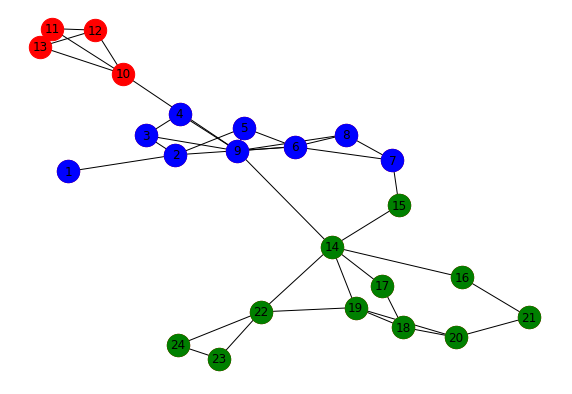

In [87]:
files = [#("zkcc-77/karate_groups.txt","zkcc-77/karate_edges_77.txt"),
        #("mexican_groups.txt","mexican_edges.txt"),
        ("strike_groups.txt", "strike_edges.txt")]
for (group_file, edge_file) in files:
    edge_list = []
    assignments = []
    with open(group_file, "r") as f:
        data = f.readline()
        while data:
            vals = data.split("\n")[0].split("\t")
            assignments.append(int(vals[0])-1)
            data = f.readline()
    f.close()
        
    n = len(assignments)
    A = np.array([[0 for i in range(n)] for j in range(n)])
    with open(edge_file, "r") as f:
        data = f.readline()
        while data:
            vals = data.split("\t")
            A[int(vals[0])-1][int(vals[1])-1] = 1
            A[int(vals[1])-1][int(vals[0])-1] = 1
            edge_list.append((int(vals[0]),int(vals[1])))
            data = f.readline()
    f.close()
    
    #define S as sharing a neighbor
    S = [[0 for i in range(len(A))] for j in range(len(A))]
    for i in range(len(S)):
        for j in range(i+1,len(S)):
            if not A[i][j] and np.dot(A[i],A[j]):
                S[i][j] = 1
                S[j][i] = 1
    #print(A)
    #print(S)
    print(greedyAgglomeration(A,None,np.sum(A)//2,None))
    print(greedyAgglomerationWrapper(A,S))
    
    print(calcModularity(A, assignments, max(assignments)+1))
    
    #get ground truth groups
    ground_truth = [[] for i in range(max(assignments)+1)]
    for i in range(len(assignments)):
        ground_truth[assignments[i]].append(i+1)
    #print(ground_truth)
    print(assignments)
    s = "["
    for i in range(len(S)):
        for j in range(len(S)):
            s += str(S[i][j])
            s += " "
        if i < len(S)-1:
            s += "; ... \n"
    s += "]"
    print(s)
    
    G = nx.Graph()
    G.add_edges_from(edge_list)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(10,7))
    # nodes
    nx.draw_networkx_nodes(G,pos,
                           node_list=ground_truth[0],
                           node_color='r',
                           node_size=500)
    nx.draw_networkx_nodes(G,pos,
                           nodelist=ground_truth[1],
                           node_color='b',
                           node_size=500)
    if len(ground_truth) > 2:
        nx.draw_networkx_nodes(G,pos,
                               nodelist=ground_truth[2],
                               node_color='g',
                               node_size=500)

    # edges
    nx.draw_networkx_edges(G,pos,width=1.0)
    nx.draw_networkx_labels(G,pos)
    plt.draw()
    plt.axis('off')
    plt.savefig(str(edge_file.split("_")[0])+".png")